In [ ]:
!pip install ordered-set
!pip install git+https://github.com/wndlovu/aquacrop.git
#!pip install aquacrop==2.2.3
!pip install numba==0.55

In [ ]:
matplotlib = 3.7.1
numpy ==1.21.0
scipy==1.10.1
statsmodels==0.13.2
numba==0.56

In [25]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from aquacrop.utils import prepare_weather, get_filepath
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement


import pandas as pd
import matplotlib
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import time
import math
import pickle 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics
#from pyswarm import pso
import os
from os import chdir, getcwd
import statistics as stats
import scipy
from scipy import stats
import hydroeval as he
import pyswarms as ps
from pyswarm import pso
import random
from ordered_set import OrderedSet
import warnings
warnings.filterwarnings('ignore')


os.chdir('/home/jupyter-wndlovu/calibration_example/') # change working directory

wd=getcwd()

from src.soils import *
from src.calibration_old import *

In [5]:
with open(wd + '/data/input_dict.pickle', 'rb') as input_data: 
    input_dict = pickle.load(input_data) 


#irrig_crop_calib = np.array(pd.read_csv(wd + '/eggs/data/sa_params/sa_results/gmd4_corn/gmd4_irrigated_corn_calibration_params_022324.txt',
                                       #sep=' ', header = None)) # full

planting_date = pd.read_csv(wd + '/data/CropPlantingDate_GMD4_WNdlovu_072423.csv')

yield_full = pd.read_csv(wd + '/data/Yield_GMD4_WNdlovu_v1_20230811.csv') 

irrig_depth = pd.read_csv(wd + '/data/IrrigationDepth_Updated_GMD4_WNdlovu_v2_20230123.csv') 

gdd = pd.read_csv(wd + '/data/CornGDD_GMD4_WNdlovu_20230827.csv') # growing degree days

# calibration_results
pso_fc = pd.read_csv(wd + '/data/calibration_results/gmd4_corn/gmd4_irrig_corn_pso_fc.csv')


defaults = pd.read_csv(wd + '/data/CropDefaultParams_GMD4_Wndlovu_022224.csv') # default model params
defaults = defaults[defaults["Crop"] == 'Maize']

irrig_depth.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
irrig_depth.dropna(inplace=True)


irrig_crop = '1' # code for irrigated corn
irrig_crop_dict = {k:v for (k,v) in input_dict.items() if irrig_crop in k}

calibration = list(irrig_crop_dict.items())
#

# getting the different datasets
gridmet = pd.concat([sublist[1][0] for sublist in calibration]) # data stored in nested list with 0 having the 
et = pd.concat([sublist[1][1] for sublist in calibration])
soil_irrig = pd.concat(SoilCompart([sublist[1][2] for sublist in calibration]))


irrig_yield = yield_full[yield_full['Irrig_status'] == 'Irrigated']


planting_date = planting_date[planting_date["Crop"] == 'Maize']
planting_date['pdate'] = pd.to_datetime(planting_date['pdate'], format='%Y-%m-%d')
planting_date['har'] = pd.to_datetime(planting_date['har'], format='%Y-%m-%d')
planting_date['late_har'] = pd.to_datetime(planting_date['late_har'], format='%Y-%m-%d')

# Convert the 'date' column back to a new column in YMD format
planting_date['pdate'] = planting_date['pdate'].dt.strftime('%Y/%m/%d')
planting_date['har'] = planting_date['har'].dt.strftime('%Y/%m/%d')
planting_date['late_har'] = planting_date['late_har'].dt.strftime('%Y/%m/%d')

# add the ccx to cgc ratio for corn
planting_date['canopy'] = 0.96/0.012494 # change for different crops

empty_df = pd.DataFrame(data = {'variable': [],
                                'value': [],
                                'calib_val': []})

In [30]:
gridmet

,crop_mn_codeyear,MinTemp,MaxTemp,Precipitation,ReferenceET,Date,Year,crop_mn_yr
370093,1_Cheyenne,-0.645666,10.891019,1.95,1.35,2006-01-01,2006,1_Cheyenne_2006
370170,1_Cheyenne,-4.276361,14.446143,0.00,1.82,2006-01-02,2006,1_Cheyenne_2006
370247,1_Cheyenne,-0.710629,18.827744,0.00,3.85,2006-01-03,2006,1_Cheyenne_2006
370324,1_Cheyenne,-4.477717,13.089686,0.00,1.90,2006-01-04,2006,1_Cheyenne_2006
370401,1_Cheyenne,-4.806794,10.428812,0.00,2.38,2006-01-05,2006,1_Cheyenne_2006
...,...,...,...,...,...,...,...,...
56678,1_Wallace,-5.439416,9.188346,0.00,1.84,2020-12-27,2020,1_Wallace_2020
56755,1_Wallace,-4.360109,0.899875,0.30,0.64,2020-12-28,2020,1_Wallace_2020
56832,1_Wallace,-9.299696,2.265713,0.03,0.56,2020-12-29,2020,1_Wallace_2020
56909,1_Wallace,-11.640520,4.285940,0.02,1.19,2020-12-30,2020,1_Wallace_2020


In [31]:
et

,crop_mn_codeyear,Date,et_ensemble_mad,et_ensemble_sam,et_ensemble_mad_min,et_ensemble_mad_max,County,Year,crop_mn_yr
0,1_Cheyenne,2016-01-01,12.179712,12.503630,5.997140,18.481335,Cheyenne,2016,1_Cheyenne_2016
1,1_Cheyenne,2016-02-01,20.561266,21.486352,11.904320,29.820267,Cheyenne,2016,1_Cheyenne_2016
2,1_Cheyenne,2016-03-01,30.849786,29.747914,20.516064,40.655444,Cheyenne,2016,1_Cheyenne_2016
3,1_Cheyenne,2016-04-01,43.420687,43.477333,30.024215,56.956882,Cheyenne,2016,1_Cheyenne_2016
4,1_Cheyenne,2016-05-01,63.240291,63.485343,42.265011,84.090065,Cheyenne,2016,1_Cheyenne_2016
...,...,...,...,...,...,...,...,...,...
595,1_Wallace,2020-08-01,129.938853,130.520847,105.367738,154.899722,Wallace,2020,1_Wallace_2020
596,1_Wallace,2020-09-01,76.201428,75.772992,59.151301,92.923014,Wallace,2020,1_Wallace_2020
597,1_Wallace,2020-10-01,40.398472,40.511584,28.948453,51.390137,Wallace,2020,1_Wallace_2020
598,1_Wallace,2020-11-01,29.524993,30.722185,14.933668,45.357869,Wallace,2020,1_Wallace_2020


In [6]:
# order influential variables to match the order of the values
influ_var = np.array(list(OrderedSet(pso_fc['variable']))).reshape(-1, 1)
influ_var

array([['ccx'],
       ['rtx'],
       ['kc'],
       ['wp'],
       ['hi'],
       ['hipsveg'],
       ['smt1'],
       ['smt2'],
       ['smt3']], dtype='<U7')

In [8]:
pso_fc_list = [pso_fc[pso_fc['iteration'] == i]['value'].tolist() for i in pso_fc['iteration'].unique()]
[pso_fc_list[3]]

[[0.889706531632827,
  1.2362797496802,
  1.0377490278835118,
  33.336042306036695,
  0.4884939042342493,
  0.6179008280297493,
  42.57689650434419,
  31.694618395459777,
  34.27293187984613]]

In [35]:
influ_var

array([['ccx'],
       ['rtx'],
       ['kc'],
       ['wp'],
       ['hi'],
       ['hipsveg'],
       ['smt1'],
       ['smt2'],
       ['smt3']], dtype='<U7')

In [9]:
# full model
unlimited_model = RunAllCounties([pso_fc_list[3]], # make nested list
                      defaults,
                      gdd,
                      empty_df,
                      planting_date,
                      gridmet,
                      soil_irrig,
                      'FC',
                      #influ_var,
                      irrig_yield,
                      irrig_depth,
                      et,
                      1,  # irrigation method (0 = rainfed, 1 = irrigated)
                      4, # beginning of growth period (ET filter)
                      11, # end of growth period (ET filter)
                      'train')



In [47]:
gdd

,eme,histart,mat,flowering,maxrooting,senescence,yldform
0,122.18451,904.22189,1735.790817,183.789616,1438.664271,1429.47479,765.790066


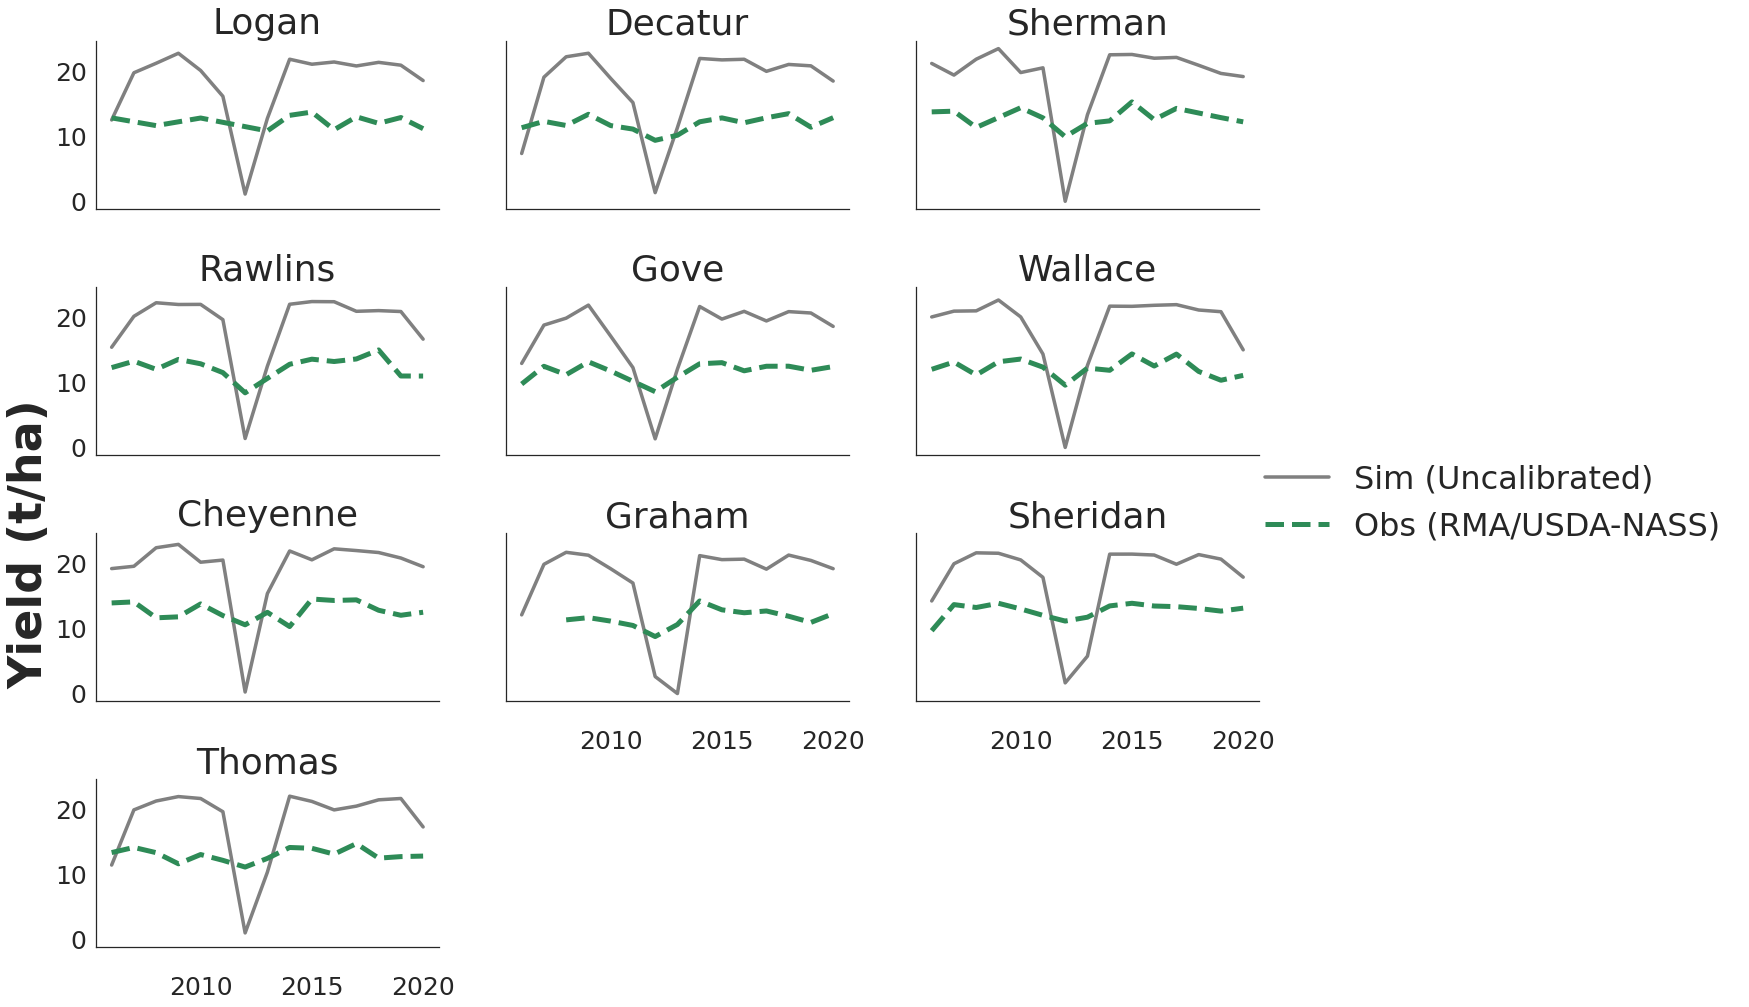

In [11]:
g = sns.FacetGrid(unlimited_model[0][0], col='County', margin_titles=True, col_wrap=3, height=4, aspect=1.5)
sns.set(style="white", font_scale=3)

# Line plots
g.map_dataframe(sns.lineplot, x="Year", y="Calib Yield (t/ha)", label='Sim', color='grey', linewidth=3.5)
g.map_dataframe(sns.lineplot, x="Year", y="YieldUSDA", label='Obs (RMA/USDA-NASS)', color='#2e8b57', linestyle='dashed', linewidth=5)




g.set_titles(col_template="{col_name}", size=70)
g.set_axis_labels("", "", size=23)
g.set_titles("{col_name}", fontsize=72)
g.tight_layout()

# Set x-axis ticks
for ax in g.axes.flat:
    ax.tick_params(axis="x", size=25, direction='out')
    ax.set_xticks([2010, 2015, 2020])
    ax.tick_params(axis='both', which='major', labelsize=25)

# Adjust space
#g.fig.subplots_adjust(top=0.5)

# Add legend and y-axis label
g.add_legend(fontsize=32)

plt.subplots_adjust(bottom = .15, left=0.065)
g.fig.text(0.015, 0.5, 'Yield (t/ha)', va='center', rotation='vertical', fontsize=46, weight='bold')

plt.show()